# SOAM FLOW RUN QUICKSTART

In the following notebook we present a simple quickstart to expose how to make a connection with a database, extract the data, transform it, generate a forecast, plot it and send a mail report using soam modules and methods in simple steps by using our soam flow.

To see these modules and methods in a disaggregated manner and further explained check the [quickstart notebook](notebook/examples/quickstart.ipynb)

Our Soam Flows are based on Prefect Flows. To see further info on these please check this [prefect docs](https://docs.prefect.io/core/concepts/flows.html).

*Note: please ignore the # NBVAL_SKIP at the beginning of the cells!*

In [1]:
%%capture #hide
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client
import pandas as pd
import numpy as np
from soam.workflow.forecaster import Forecaster
from soam.models.prophet import SkProphet
from soam.utilities.utils import add_future_dates
from soam.reporting import mail_report
import datetime
from soam.core import SoamFlow
from prefect import task
from soam.plotting.forecast_plotter import ForecastPlotterTask
from soam.constants import PLOT_CONFIG
from copy import deepcopy
from pathlib import Path

## Extraction
DB Connection using `muttlib`. <br>
`SQL Query` constructed <br>
`SOAM Extractor` object initialization.

In [2]:
sqlite_cfg = {
    "db_type": "sqlite",
    "database": "soam_quickstart.db"
}

sqlite_client = get_client(sqlite_cfg)[1]

In [3]:
build_query_kwargs={
    'columns': '*',
    'timestamp_col': 'date',
    'start_date': "2021-03-01",
    'end_date': "2021-03-20",
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'order_by': ["date ASC"]
}

In [4]:
extractor = TimeSeriesExtractor(db=sqlite_client, table_name='stock')

## Preprocessing
Tasks created upon functions based on custom transformations.

In [5]:
@task()
def transform_df_for_scaler(df: pd.DataFrame):
    data = np.array([df.avg_price])
    data = np.swapaxes(data, 0, 1)
    return data

@task()
def transform_df_format(df: pd.DataFrame):    
    df = df[['date', 'avg_price']]
    df.rename(columns = {
        'date': 'ds',
        'avg_price': 'y'}, inplace = True)
    df.ds =  pd.to_datetime(df.ds, infer_datetime_format=True)
    df = add_future_dates(df, periods=7, frequency="d")
    return df

## Forecasting
Forecasting model selected: `FBProphet`. <br>
`SOAM Forecaster` object initialization.

In [6]:
my_model = SkProphet(weekly_seasonality=False, daily_seasonality=True)
forecaster = Forecaster(my_model, output_length=7)

## Plotting and Reporting
Plotting task based on the `SOAM Forecast Plotter` object.

In [7]:
plot_config = deepcopy(PLOT_CONFIG)
forecast_plotter = ForecastPlotterTask(path = Path('img/applestockprice'), metric_name = "Apple's Stock Price", plot_config = plot_config)

`SOAM Mail Report` object initialization.

In [8]:
# NBVAL_SKIP
mr = mail_report.MailReportTask(
    # recipients mails separated by commas
    mail_recipients_list = ["mail@gmail.com"],
    # the metric name will be in the title
    metric_name = "Stocks Forecast" 
)

# this refer to the start and end of the historic values. they are used since they are part of plot filename. format: yyyymmddhh.
start_date='2021030100'
end_date='2021031900'

# SoaMFlow

Putting all together using `SoaMFlow`.

In [9]:
# NBVAL_SKIP
with SoamFlow(name = "flow") as flow:
    # EXTRACTION
    df = extractor(build_query_kwargs)
    # PRE PROCESSING
    data = transform_df_for_scaler(df = df)
    df = transform_df_format(df = df)
    # FORECASTING
    predictions, time_series, model = forecaster(time_series=df)
    # PLOTTING
    forecast_plotter(time_series, predictions)
    # REPORTING
    mr(
    current_date = "2021-04-12",
    plot_filename = f'img/applestockprice/0_forecast_{start_date}_{end_date}_.png'
)

/home/eugenio/MUTT/soam/soam_venv/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/eugenio/MUTT/soam/soam_venv/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<Success: "All reference tasks succeeded.">

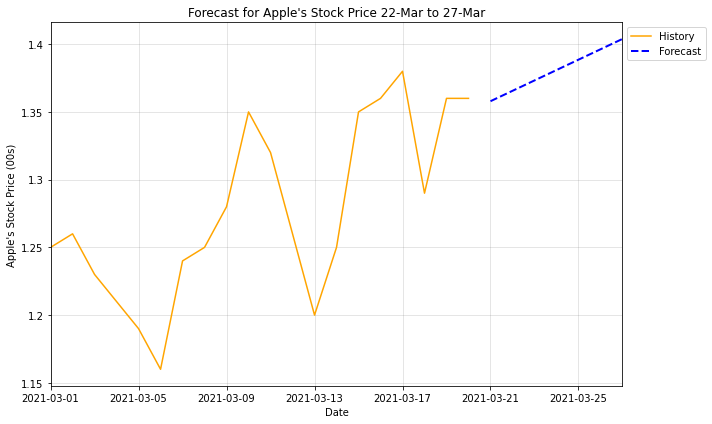

In [10]:
# NBVAL_SKIP
flow.run()

<center>Voilà!</center>